# Demo on PBMC dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
import pandas as pd
import scanpy as sc
import scvi

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

import q2r_uncertainty
import diff2atlas


Global seed set to 0


In [3]:
import celltypist

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

import anndata2ri
anndata2ri.activate()

ValueError: r_home is None. Try python -m rpy2.situation

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(tidyverse)
library(patchwork)

### Load dataset

Built in [here](https://github.com/emdann/query2reference_uncertainty/blob/master/notebooks/PBMC_metanalysis/20220531_PBMC_metadata.ipynb)

In [7]:
data_dir = '/nfs/team205/ed6/data/PBMC_CZI_integration_filtered/'
adata = sc.read_h5ad(data_dir + 'PBMC_merged.normal.subsample500cells.h5ad')

In [8]:
sample_obs = pd.read_csv(data_dir + 'PBMC_sample_metadata.normal.csv')

In [9]:
%%R -i sample_obs
dim(sample_obs)

[1] 1268   11


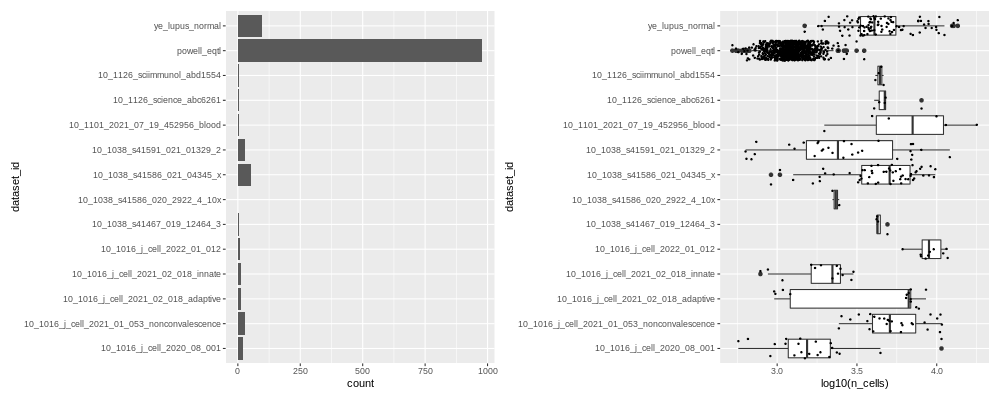

In [10]:
%%R -w 1000 -h 400
sample_obs %>%
    ggplot(aes(dataset_id)) +
    geom_bar( ) +
    coord_flip() +
sample_obs %>%
ggplot(aes(dataset_id, log10(n_cells))) +
geom_boxplot() +
geom_jitter(size=0.5) +
scale_fill_viridis_c() +
coord_flip()

### Design

- select one dataset to be query
- split in perturb and control (don't use two different datasets for now, otherwise you need to match)
- remove query-specific cluster from control and reference  

In [64]:
batch_obs = 'dataset_id'
query_dataset = '10_1038_s41591_021_01329_2' ## Stephenson et al

## Select query batch
query = np.array([s in query_dataset for s in adata.obs[batch_obs]])
adata.obs["is_train"] = (~query).astype(int)
adata.obs["is_test"] = query.astype('int')

## Split in case and ctrl
np.random.seed(40)
query_samples = sample_obs[sample_obs.dataset_id == query_dataset].sample_id
samples_design = np.random.choice((0,1), len(query_samples))
adata.obs['is_ctrl'] = adata.obs['sample_id'].isin(query_samples[samples_design==1]).astype(int)
adata.obs.loc[adata.obs['is_ctrl'] == 1, 'is_test'] = 0

In [65]:
sample_obs.index = sample_obs.sample_id.copy()
sample_obs.loc[query_samples[samples_design==1]]

,sample_id,sex,tissue,ethnicity,disease,assay,assay_ontology_term_id,donor_id,dataset_id,development_stage,n_cells
sample_id,,,,,,,,,,,
BGCV01_CV0904,BGCV01_CV0904,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0904,10_1038_s41591_021_01329_2,fourth decade human stage,6853
BGCV02_CV0902,BGCV02_CV0902,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0902,10_1038_s41591_021_01329_2,sixth decade human stage,2599
BGCV04_CV0911,BGCV04_CV0911,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0911,10_1038_s41591_021_01329_2,fifth decade human stage,1905
BGCV10_CV0939,BGCV10_CV0939,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0939,10_1038_s41591_021_01329_2,eighth decade human stage,1719
BGCV13_CV0934,BGCV13_CV0934,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0934,10_1038_s41591_021_01329_2,third decade human stage,3408
BGCV15_CV0944,BGCV15_CV0944,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0944,10_1038_s41591_021_01329_2,sixth decade human stage,634
MH8919176,MH8919176,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919176,10_1038_s41591_021_01329_2,third decade human stage,3217
MH8919178,MH8919178,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919178,10_1038_s41591_021_01329_2,sixth decade human stage,7016
MH8919179,MH8919179,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919179,10_1038_s41591_021_01329_2,fourth decade human stage,4316


In [66]:
sample_obs.loc[query_samples[samples_design==0]]

,sample_id,sex,tissue,ethnicity,disease,assay,assay_ontology_term_id,donor_id,dataset_id,development_stage,n_cells
sample_id,,,,,,,,,,,
BGCV01_CV0902,BGCV01_CV0902,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0902,10_1038_s41591_021_01329_2,sixth decade human stage,1285
BGCV05_CV0929,BGCV05_CV0929,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0929,10_1038_s41591_021_01329_2,seventh decade human stage,1466
BGCV08_CV0915,BGCV08_CV0915,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0915,10_1038_s41591_021_01329_2,fifth decade human stage,1940
BGCV09_CV0917,BGCV09_CV0917,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0917,10_1038_s41591_021_01329_2,seventh decade human stage,2924
BGCV12_CV0926,BGCV12_CV0926,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0926,10_1038_s41591_021_01329_2,seventh decade human stage,2622
BGCV14_CV0940,BGCV14_CV0940,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,CV0940,10_1038_s41591_021_01329_2,seventh decade human stage,2958
MH8919177,MH8919177,female,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919177,10_1038_s41591_021_01329_2,sixth decade human stage,2223
MH8919231,MH8919231,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919231,10_1038_s41591_021_01329_2,fourth decade human stage,690
MH8919281,MH8919281,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919281,10_1038_s41591_021_01329_2,third decade human stage,724


In [77]:
# Remove query-specific population from train and ctrl cells
population_obs = 'cell_type'
ct_size = adata.obs[['sample_id', 'is_ctrl', 'is_test', 'is_train', 'cell_type']].groupby(['sample_id', 'is_ctrl', 'is_test', 'is_train', 'cell_type']).size().reset_index()

In [80]:
ct_size = ct_size[ct_size[0] > 0]

In [88]:
ct_size['group'] = ct_size[['is_ctrl', 'is_test', 'is_train']].idxmax(1)

In [89]:
%%R -i ct_size
dim(ct_size)

[1] 23549     7


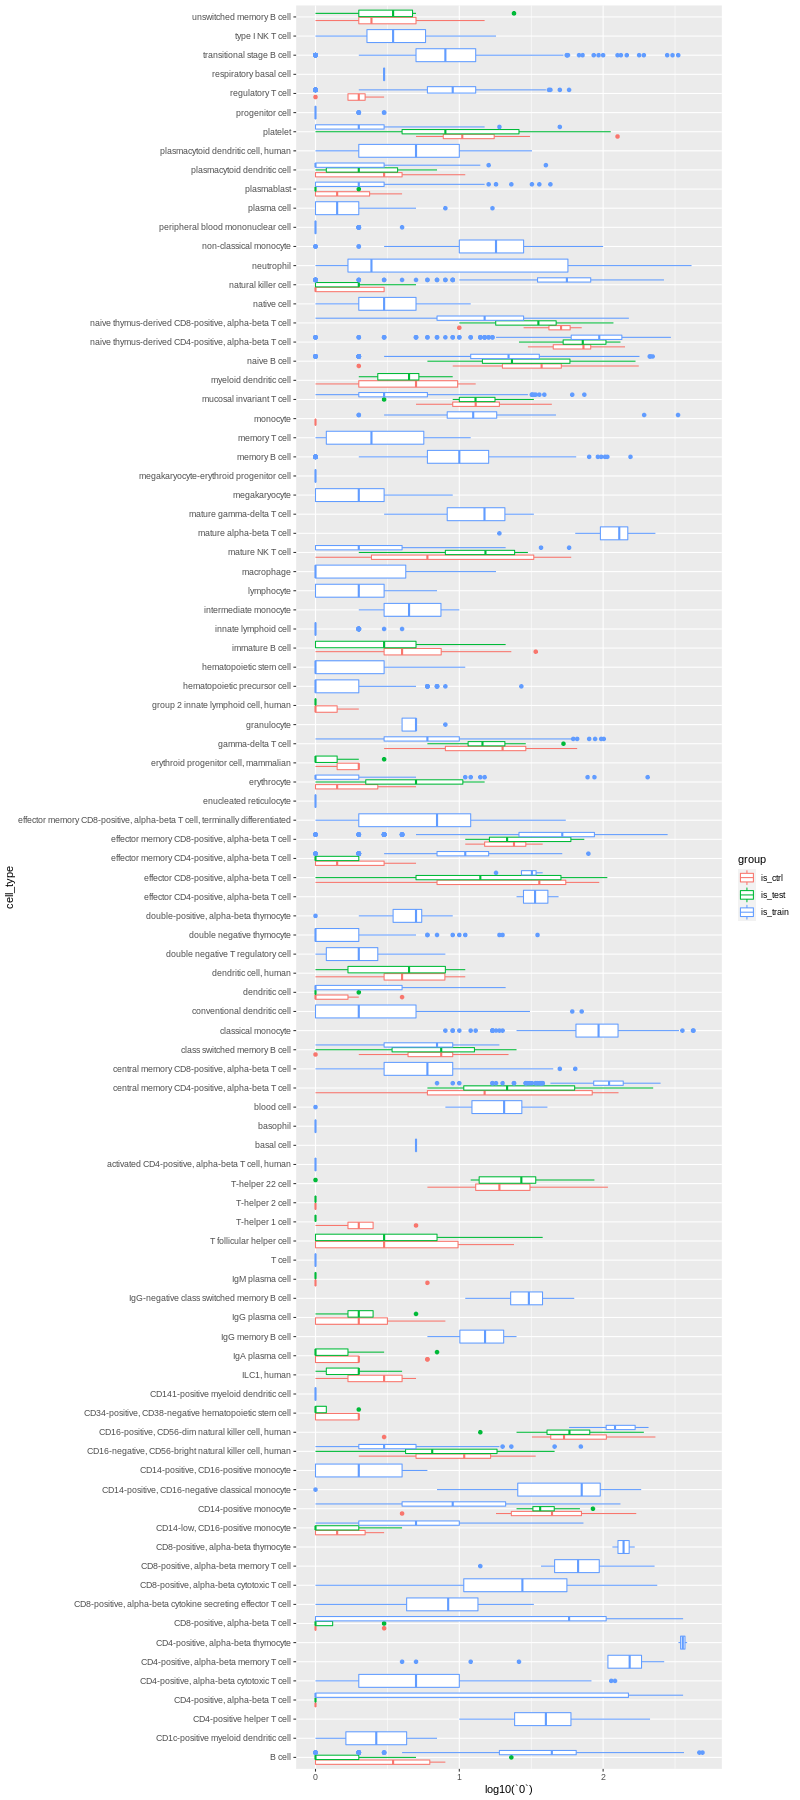

In [92]:
%%R -h 1800 -w 800
ct_size %>%
ggplot(aes(cell_type, log10(`0`))) +
geom_boxplot(aes(color=group)) +
coord_flip()

In [94]:
perturb_pop = ["naive B cell"]
adata.obs.loc[(adata.obs[population_obs].isin(perturb_pop)),
              'is_train'] = 0
adata.obs.loc[(adata.obs[population_obs].isin(
        perturb_pop)), 'is_ctrl'] = 0

In [112]:
# test that no cell is assigned to multiple splits
assert adata.obs[['is_train', 'is_test', 'is_ctrl']].sum(1).max() == 1

# test that perturbed population is in condition dataset only
assert adata[adata.obs['is_test'] == 1].obs[population_obs].isin(perturb_pop).sum() > 0
assert adata[adata.obs['is_train'] == 1].obs[population_obs].isin(perturb_pop).sum() == 0
assert adata[adata.obs['is_ctrl'] == 1].obs[population_obs].isin(perturb_pop).sum() == 0

In [120]:
adata_atlas = adata[adata.obs['is_train']==1].copy()
adata_ctrl = adata[adata.obs['is_ctrl']==1].copy()
adata_query = adata[adata.obs['is_test']==1].copy()

In [127]:
gdrive_dir = '/home/jovyan/mount/gdrive/query2reference/PBMC_CZIintegration_data/'
adata_atlas.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.atlas.h5ad')
adata_query.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.query.h5ad')
adata_ctrl.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.ctrl.h5ad')

With scVI/scArches
---

In [5]:
gdrive_dir = '/home/jupyter/mount/gdrive/query2reference/PBMC_CZIintegration_data/'
adata_atlas = sc.read_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.atlas.h5ad')
adata_query = sc.read_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.query.h5ad')
adata_ctrl = sc.read_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.ctrl.h5ad')

### Atlas model

In [6]:
adata_atlas.X = adata_atlas.layers['counts'].copy()

In [7]:
del adata_atlas.uns['log1p']

In [8]:
## Feature selection on reference only
n_hvgs = 5000
overwrite_models = False

if 'log1p' not in adata_atlas.uns.keys():
    sc.pp.normalize_per_cell(adata_atlas)
    sc.pp.log1p(adata_atlas)

sc.pp.highly_variable_genes(
    adata_atlas,
    n_top_genes=n_hvgs,
    subset=True
)

In [9]:
hvgs = adata_atlas.var_names.values

In [10]:
## Some utils
def clean_pop_name(string):
   return(''.join(e if e.isalnum() else '_' for e in string))

In [11]:
population_obs = 'cell_type'
perturb_pop = ["naive B cell"]
sim_id = f"qPBMC_500cells_demo_perturb_{population_obs}{clean_pop_name('-'.join(perturb_pop))}"
sim_id
if not os.path.exists(gdrive_dir + sim_id + "_models"):
    os.mkdir(gdrive_dir + sim_id + "_models")

In [20]:
## Train reference model
if not os.path.exists(gdrive_dir + sim_id + "_models/model_reference") or overwrite_models:
    vae_ref = q2r_uncertainty.train_models.train_scVI._train_model(adata_atlas, hvgs, batch_col='sample_id')
    vae_ref.save(gdrive_dir + sim_id + "_models/model_reference", overwrite=True)

INFO     Using batches from adata.obs["batch"]                                               


Using batches from adata.obs["batch"]


INFO     No label_key inputted, assuming all cells have same label                           


No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Successfully registered anndata object containing 589174 cells, 5000 vars, 1225     
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


Successfully registered anndata object containing 589174 cells, 5000 vars, 1225 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14/14: 100%|██████████| 14/14 [09:30<00:00, 40.73s/it, loss=1.09e+03, v_num=1]


In [16]:
adata_atlas.obs['batch'] = adata_atlas.obs['sample_id'].copy()

In [17]:
vae_ref = scvi.model.SCVI.load(gdrive_dir + sim_id + "_models/model_reference", adata=adata_atlas)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        


.obs[_scvi_labels] not found in target, assuming every cell is same category


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 589174 cells, 5000 vars, 1225     
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


Successfully registered anndata object containing 589174 cells, 5000 vars, 1225 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


In [21]:
adata_ctrl.layers['counts'] = adata_ctrl.X.copy()
adata_query.layers['counts'] = adata_query.X.copy()

In [22]:
## Map query datasets 
vae_ctrl_fit = q2r_uncertainty.train_models.train_scVI._fit_model(adata_ctrl, vae_ref, batch_col='sample_id')
vae_ctrl_fit.save(gdrive_dir + sim_id + "_models/model_fit_ctrl/", overwrite=True)
vae_query_fit_ref = q2r_uncertainty.train_models.train_scVI._fit_model(adata_query, vae_ref, batch_col='sample_id')
vae_query_fit_ref.save(gdrive_dir + sim_id + "_models/model_fit_query/", overwrite=True)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        


.obs[_scvi_labels] not found in target, assuming every cell is same category


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 7214 cells, 5000 vars, 1241       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


Successfully registered anndata object containing 7214 cells, 5000 vars, 1241 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [01:32<00:00,  2.16it/s, loss=1.6e+03, v_num=1] 
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        


.obs[_scvi_labels] not found in target, assuming every cell is same category


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 7000 cells, 5000 vars, 1239       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


Successfully registered anndata object containing 7000 cells, 5000 vars, 1239 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [01:32<00:00,  2.17it/s, loss=1.5e+03, v_num=1] 


### Control model

In [24]:
## Feature selection on reference only
n_hvgs = 5000
overwrite_models = False

if 'log1p' not in adata_ctrl.uns.keys():
    sc.pp.normalize_per_cell(adata_ctrl)
    sc.pp.log1p(adata_ctrl)

sc.pp.highly_variable_genes(
    adata_ctrl,
    n_top_genes=n_hvgs,
    subset=True
)

In [25]:
hvgs = adata_ctrl.var_names.values

In [28]:
## Train reference model
if not os.path.exists(gdrive_dir + sim_id + "_models/model_ctrl") or overwrite_models:
    vae_ctrl = q2r_uncertainty.train_models.train_scVI._train_model(adata_ctrl, hvgs, batch_col='sample_id')
    vae_ctrl.save(gdrive_dir + sim_id + "_models/model_ctrl", overwrite=True)

INFO     Using batches from adata.obs["batch"]                                               


Using batches from adata.obs["batch"]


INFO     No label_key inputted, assuming all cells have same label                           


No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Successfully registered anndata object containing 7214 cells, 5006 vars, 16 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Successfully registered anndata object containing 7214 cells, 5006 vars, 16 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


Please do not further modify adata until model is trained.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [03:18<00:00,  2.02it/s, loss=1.45e+03, v_num=1]


In [29]:
vae_query_fit_ctrl = q2r_uncertainty.train_models.train_scVI._fit_model(adata_query, vae_ctrl, batch_col='sample_id')
vae_query_fit_ctrl.save(gdrive_dir + sim_id + "_models/model_fit_query_2ctrl/", overwrite=True)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        


.obs[_scvi_labels] not found in target, assuming every cell is same category


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 7000 cells, 5006 vars, 30 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Successfully registered anndata object containing 7000 cells, 5006 vars, 30 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [01:26<00:00,  2.32it/s, loss=1.46e+03, v_num=1]


### Co-embeddings

In [31]:
adata_atlas = sc.read_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.atlas.h5ad')
adata_query = sc.read_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.query.h5ad')
adata_ctrl = sc.read_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.ctrl.h5ad')

In [46]:
## perturbation-atlas
pa_design_adata = adata_atlas.concatenate(adata_query, batch_key='dataset', batch_categories=['atlas', 'query'])
pa_design_adata.layers['counts'] = pa_design_adata.X.copy()
pa_design_adata.obs['batch'] = pa_design_adata.obs['sample_id'].copy()

In [47]:
pa_design_adata.obsm["X_scVI"] = vae_query_fit_ref.get_latent_representation(pa_design_adata[:,vae_query_fit_ref.adata.var_names])

INFO     Received view of anndata, making copy.                                              


Received view of anndata, making copy.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               


Input adata not setup with scvi. attempting to transfer anndata setup


INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        


.obs[_scvi_labels] not found in target, assuming every cell is same category


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 596174 cells, 5000 vars, 1239     
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


Successfully registered anndata object containing 596174 cells, 5000 vars, 1239 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


In [48]:
## perturbation-ctrl
pc_design_adata = adata_ctrl.concatenate(adata_query, batch_key='dataset', batch_categories=['ctrl', 'query'])
pc_design_adata.layers['counts'] = pc_design_adata.X.copy()
pc_design_adata.obs['batch'] = pc_design_adata.obs['sample_id'].copy()

In [49]:
pc_design_adata.obsm["X_scVI"] = vae_query_fit_ctrl.get_latent_representation(pc_design_adata[:,vae_query_fit_ctrl.adata.var_names])

INFO     Received view of anndata, making copy.                                              


Received view of anndata, making copy.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               


Input adata not setup with scvi. attempting to transfer anndata setup


INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        


.obs[_scvi_labels] not found in target, assuming every cell is same category


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 14214 cells, 5006 vars, 30        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


Successfully registered anndata object containing 14214 cells, 5006 vars, 30 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


In [50]:
## perturbation-ctrl
ac_design_adata = adata_atlas.concatenate(adata_ctrl, batch_key='dataset', batch_categories=['atlas', 'ctrl'])
ac_design_adata.layers['counts'] = ac_design_adata.X.copy()
ac_design_adata.obs['batch'] = ac_design_adata.obs['sample_id'].copy()

In [51]:
ac_design_adata.obsm["X_scVI"] = vae_ctrl_fit.get_latent_representation(ac_design_adata[:,vae_ctrl_fit.adata.var_names])

INFO     Received view of anndata, making copy.                                              


Received view of anndata, making copy.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               


Input adata not setup with scvi. attempting to transfer anndata setup


INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        


.obs[_scvi_labels] not found in target, assuming every cell is same category


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 596388 cells, 5000 vars, 1241     
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


Successfully registered anndata object containing 596388 cells, 5000 vars, 1241 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


In [52]:
pac_design_adata = pa_design_adata.concatenate(ac_design_adata)

In [53]:
for adata in [pa_design_adata, pc_design_adata, pac_design_adata]:
    sc.pp.neighbors(adata, n_neighbors=30, use_rep="X_scVI")
    sc.tl.umap(adata)

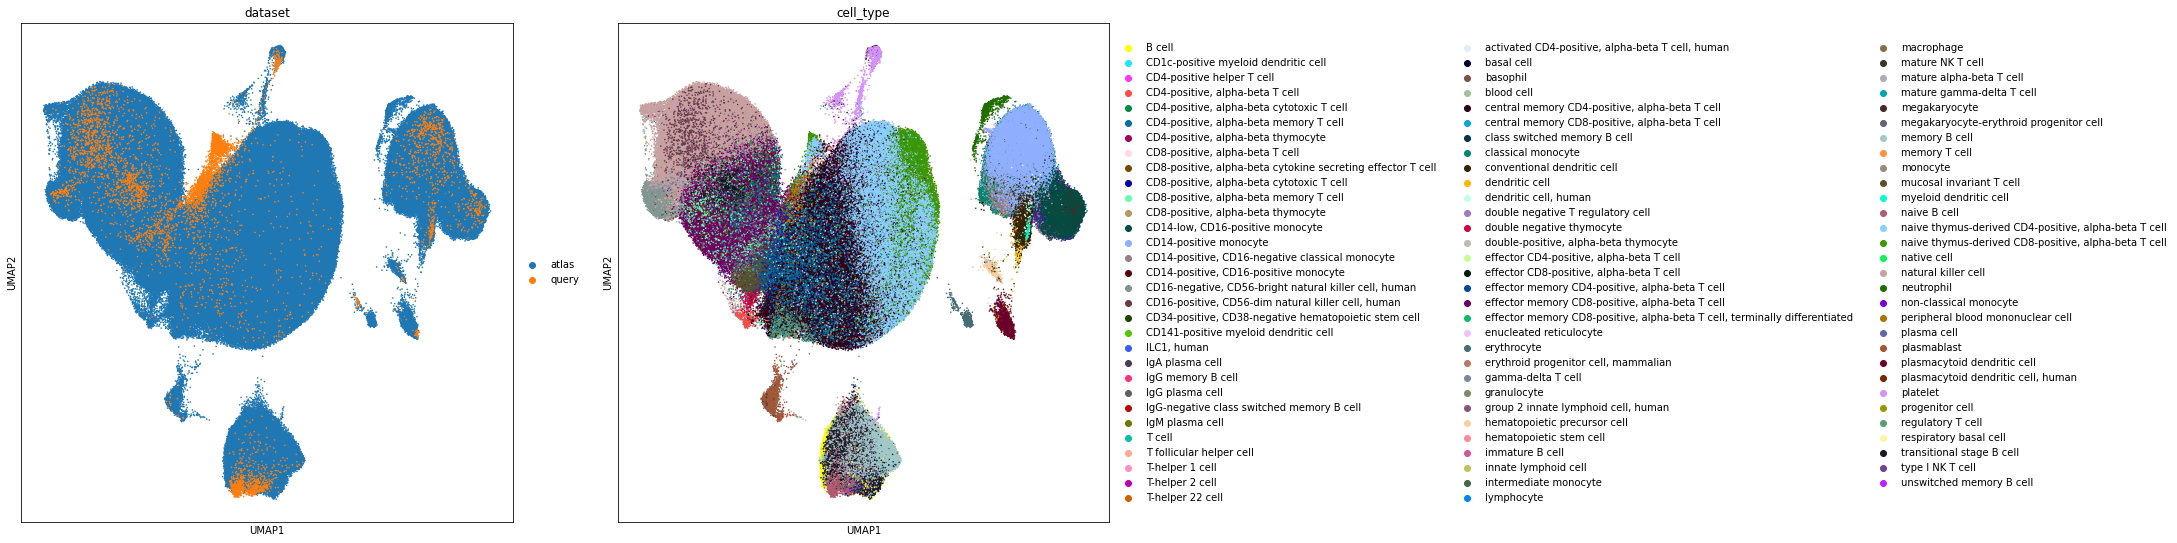

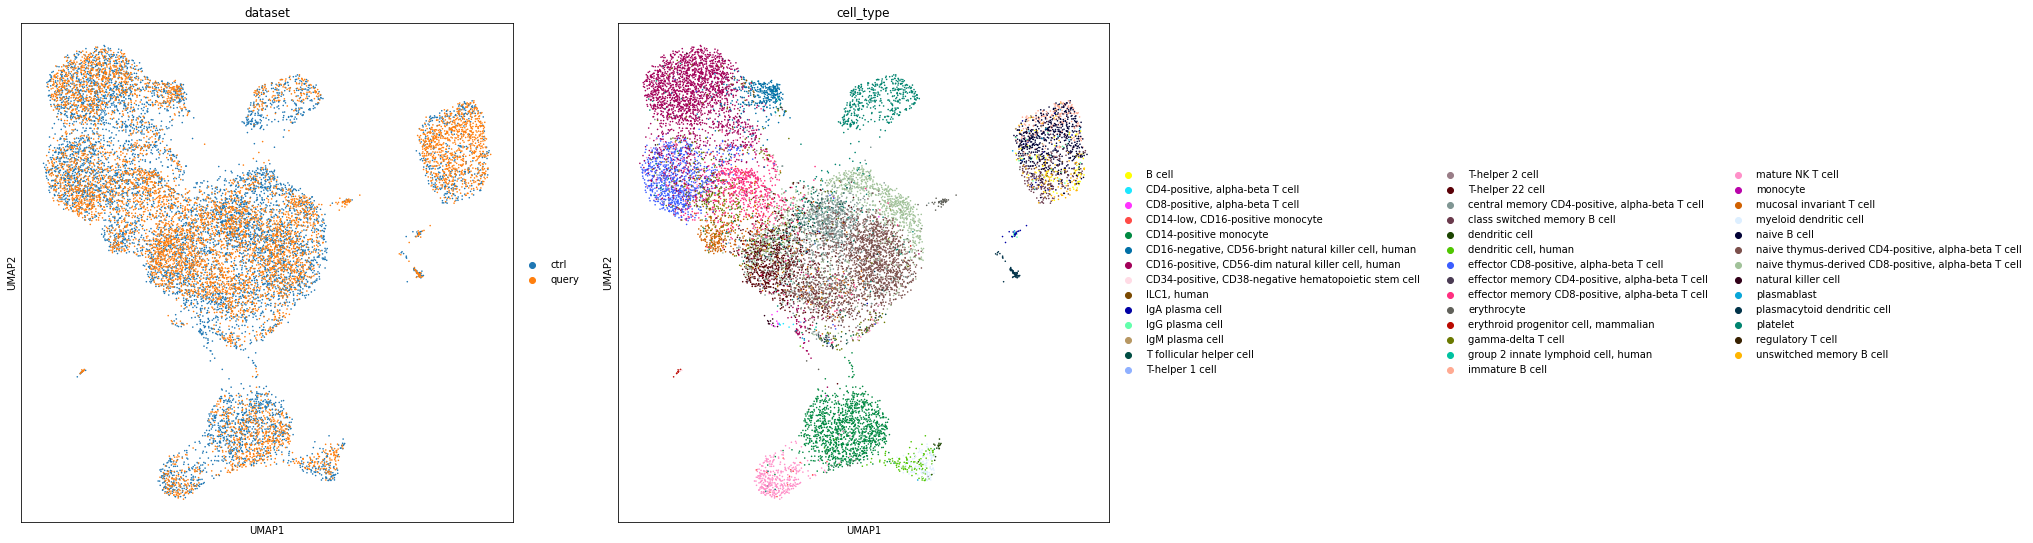

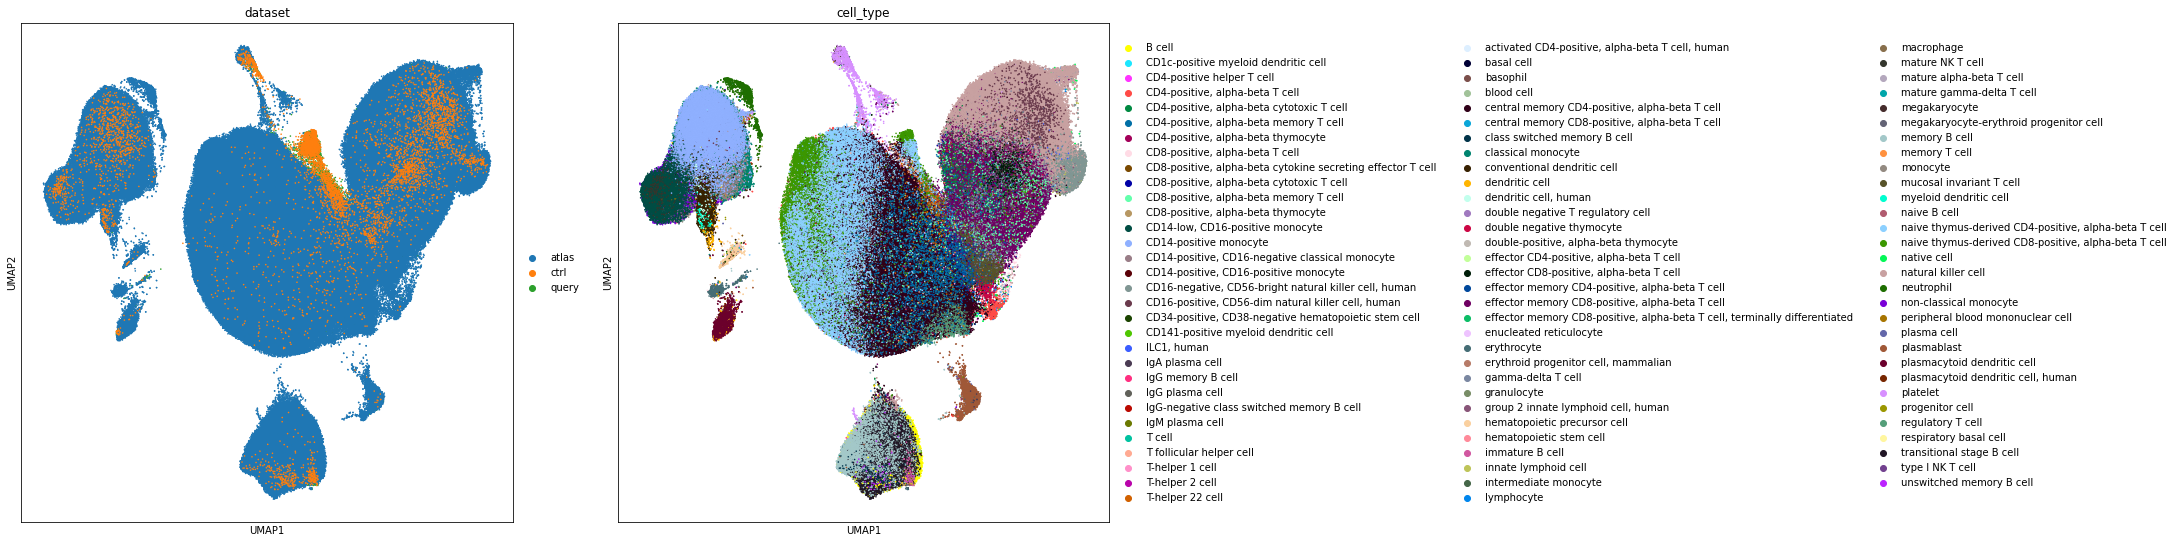

In [65]:
plt.rcParams['figure.figsize'] = [9,9]
sc.pl.umap(pa_design_adata, color=['dataset', 'cell_type'], size=10)
sc.pl.umap(pc_design_adata, color=['dataset', 'cell_type'], size=10)
sc.pl.umap(pac_design_adata, color=['dataset', 'cell_type'], size=10)

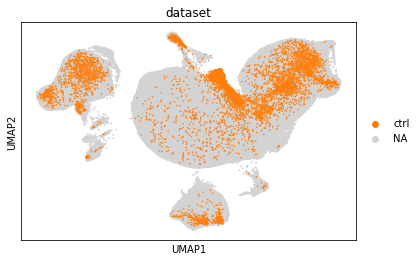

In [59]:
sc.pl.umap(pac_design_adata, color='dataset', size=10, groups=['ctrl'])

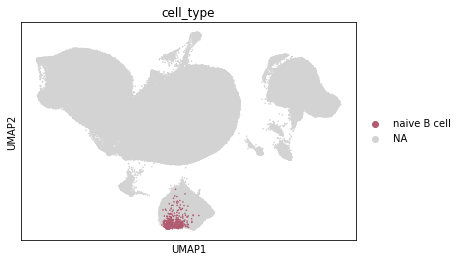

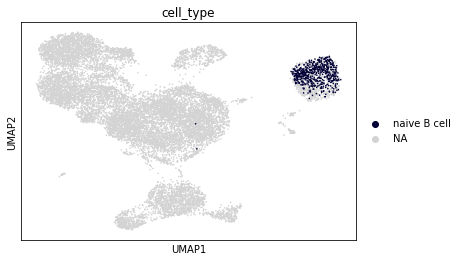

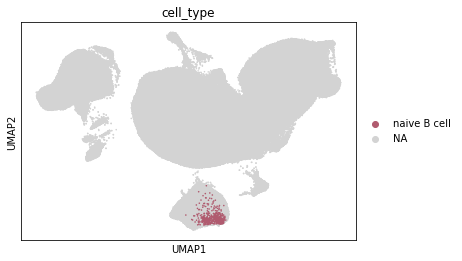

In [64]:
sc.pl.umap(pa_design_adata, color=population_obs, size=10, groups=perturb_pop)
sc.pl.umap(pc_design_adata, color=population_obs, size=10, groups=perturb_pop)
sc.pl.umap(pac_design_adata, color=population_obs, size=10, groups=perturb_pop)

### Quantify uncertainty

In [70]:
from q2r_uncertainty.uncertainty_metrics import scArches_uncertainty, KNNconservation, trueVSpred_gex_cosine 
from q2r_uncertainty.predict_gex import generative_posterior_mean

# pac_design_adata.obs['dataset_group'] = pac_design_adata.obs['dataset']
# pc_design_adata.obs['dataset_group'] = pc_design_adata.obs['dataset']
# pa_design_adata.obs['dataset_group'] = pa_design_adata.obs['dataset']

pa_design_adata.obs['dataset'] = ['reference' if x=='atlas' else 'query' for x in pa_design_adata.obs['dataset_group']] 
pc_design_adata.obs['dataset'] = ['reference' if x=='ctrl' else 'query' for x in pc_design_adata.obs['dataset_group']] 
pac_design_adata.obs['dataset'] = ['reference' if x=='atlas' else 'query' for x in pac_design_adata.obs['dataset_group']] 

pa_design_adata_q = pa_design_adata[pa_design_adata.obs['dataset'] == 'query'].copy()
pac_design_adata_q = pac_design_adata[pac_design_adata.obs['dataset'] == 'query'].copy()
pc_design_adata_q = pc_design_adata[pc_design_adata.obs['dataset'] == 'query'].copy()

In [80]:
pa_design_adata.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.PA_design.coembedding.h5ad')
pac_design_adata.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.PAC_design.coembedding.h5ad')
pc_design_adata.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.PC_design.coembedding.h5ad')


... storing 'dataset' as categorical
... storing 'dataset' as categorical
... storing 'dataset' as categorical


In [68]:
## scArches label uncertainty
pa_design_adata.obs['scArches_unc'] = np.nan
pa_design_adata.obs.loc[pa_design_adata.obs.dataset == 'query', 'scArches_unc'] = scArches_uncertainty(merged_adata=pa_design_adata, q2r_emb='X_scVI', anno_col='cell_type')
pac_design_adata.obs['scArches_unc'] = np.nan
pac_design_adata.obs.loc[pac_design_adata.obs.dataset == 'query', 'scArches_unc'] = scArches_uncertainty(merged_adata=pac_design_adata, q2r_emb='X_scVI', anno_col='cell_type')
pc_design_adata.obs['scArches_unc'] = np.nan
pc_design_adata.obs.loc[pc_design_adata.obs.dataset == 'query', 'scArches_unc'] = scArches_uncertainty(merged_adata=pc_design_adata, q2r_emb='X_scVI', anno_col='cell_type')

5.672593593597412


MemoryError: Unable to allocate 30.7 GiB for an array with shape (7000, 589174) and data type float64

In [85]:
import sklearn.metrics
import scipy.sparse

def trueVSpred_gex_cosine(
    vae,
    n_samples=50,
    scale: bool = False
):
    '''
    Compute cosine distance between true and predicted gene expression profile

    Params:
    ------
    - adata: AnnData object
    - pred_layer: element in adata.layers storing predicted gene expression profile
    - true_layer: element in adata.layers storing true gene expression profile
    - scale: should gex profiles be scaled before computing the distance (== calculating correlation)    

    Returns:
    -------
    None, modifies adata in place adding `adata.obs['trueVSpred_gex_cosine']`
    '''
    adata = vae.adata.copy()
    if 'log1p' not in adata.uns.keys():
        sc.pp.normalize_per_cell(adata)
        sc.pp.log1p(adata)
    X_true = adata.X.copy()

    post_sample = vae.posterior_predictive_sample(n_samples=n_samples)
    post_sample = np.log1p(post_sample)
    X_pred = post_sample.mean(2)
    
    if scipy.sparse.issparse(X_true):
        X_true = X_true.toarray()
    if scipy.sparse.issparse(X_pred):
        X_pred = X_pred.toarray()

    if scale:
        X_pred = sc.pp.scale(X_pred, zero_center=False)
        X_true = sc.pp.scale(X_true, zero_center=False)

    cosine_all = sklearn.metrics.pairwise.cosine_distances(X_true, X_pred)
    adata.obs['trueVSpred_gex_cosine'] = np.diag(cosine_all)
    return(adata.obs['trueVSpred_gex_cosine'])

In [89]:
unc_fit_ctrl = trueVSpred_gex_cosine(vae_query_fit_ctrl, n_samples=50)
unc_fit_ref = trueVSpred_gex_cosine(vae_query_fit_ref, n_samples=50)
unc_ctrl = trueVSpred_gex_cosine(vae_ctrl_fit, n_samples=50)

In [124]:
pac_design_adata.obs['pred_unc'] = np.nan
pac_design_adata.obs.loc[unc_fit_ref.index +'-query-0', 'pred_unc'] = unc_fit_ref
pac_design_adata.obs.loc[unc_ctrl.index +'-ctrl-1', 'pred_unc'] = unc_ctrl

In [126]:
pa_design_adata.obs['pred_unc'] = np.nan
pa_design_adata.obs.loc[unc_fit_ref.index +'-query', 'pred_unc'] = unc_fit_ref

In [127]:
pc_design_adata.obs['pred_unc'] = np.nan
pc_design_adata.obs.loc[unc_fit_ctrl.index +'-query', 'pred_unc'] = unc_fit_ctrl

In [128]:
pa_design_adata.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.PA_design.coembedding.h5ad')
pac_design_adata.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.PAC_design.coembedding.h5ad')
pc_design_adata.write_h5ad(gdrive_dir + 'PBMC_merged.normal.subsample500cells.PC_design.coembedding.h5ad')

With CellTypist
---

### Train celltypist reference model

In [123]:
adata_atlas.layers['counts'] = adata_atlas.X.copy()

In [124]:
sc.pp.normalize_total(adata_atlas, target_sum=10000)
sc.pp.log1p(adata_atlas)

In [125]:
new_model = celltypist.train(adata_atlas, labels = 'cell_type', n_jobs = 10, feature_selection = True)

🍳 Preparing data before training
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
⚠️ Warning: it may take a long time to train this dataset with 589174 cells and 11724 genes, try to downsample cells and/or restrict genes to a subset (e.g., hvgs)


KeyboardInterrupt: 

In [ ]:
new_model.write(data_dir + 'PBMC_merged.normal.subsample500cells.celltypist_model.pkl')

### Predict cell type labels

In [19]:
adata_query.layers['counts'] = adata_query.X.copy()
adata_ctrl.layers['counts'] = adata_ctrl.X.copy()

In [26]:
adata_query.var_names = adata_query.var['SYMBOL'].values.astype('str')
adata_ctrl.var_names = adata_ctrl.var['SYMBOL'].values.astype('str')

In [20]:
sc.pp.normalize_total(adata_query, target_sum=10000)
sc.pp.log1p(adata_query)

In [27]:
predictions_query = celltypist.annotate(adata_query, 
                                  model = data_dir + 'PBMC_merged.normal.subsample500cells.celltypist_model.pkl',
                        majority_voting = False)

🔬 Input data has 56122 cells and 29453 genes
🔗 Matching reference genes in the model
🧬 3058 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


In [29]:
sc.pp.normalize_total(adata_ctrl, target_sum=10000)
sc.pp.log1p(adata_ctrl)

In [30]:
predictions_ctrl = celltypist.annotate(adata_ctrl, 
                                  model = data_dir + 'PBMC_merged.normal.subsample500cells.celltypist_model.pkl',
                        majority_voting = False)

🔬 Input data has 30703 cells and 29453 genes
🔗 Matching reference genes in the model
🧬 3058 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
